<a href="https://colab.research.google.com/github/HyVeel/eksploracja-danych/blob/main/zaj11/titanic_tree_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analiza zbioru Titanic

**Cel:** Przewidzieć, którzy pasażerowie przeżyli katastrofę Titanica

**Zmienna docelowa:** survived (0 = nie przeżył, 1 = przeżył)

**Cechy do wykorzystania:**
- pclass - klasa podróży (1, 2, 3)
- sex - płeć
- age - wiek
- sibsp - liczba rodzeństwa/małżonków na pokładzie
- parch - liczba rodziców/dzieci na pokładzie
- fare - cena biletu
- embarked - port zaokrętowania (C, Q, S)


## Wczytanie zbioru Titanic

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score,
                             roc_curve, classification_report)
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

pd.reset_option("display")
pd.options.display.expand_frame_repr = False

df = sns.load_dataset("titanic")

## Część 1: Przygotowanie danych

### 2.1 Usuń kolumny, które nie będą przydatne w modelowaniu (np. deck - za dużo braków).

In [116]:
target_column = "survived"
feature_columns = [
    "pclass",
    "sex",
    "age",
    "sibsp",
    "parch",
    "fare",
    "embarked"
]

df = df[feature_columns + [target_column]]

print(f"\n---info:\n{df.info()}")
print(f"\n---head:\n{df.head()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    891 non-null    int64  
 1   sex       891 non-null    object 
 2   age       714 non-null    float64
 3   sibsp     891 non-null    int64  
 4   parch     891 non-null    int64  
 5   fare      891 non-null    float64
 6   embarked  889 non-null    object 
 7   survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB

---info:
None

---head:
   pclass     sex   age  sibsp  parch     fare embarked  survived
0       3    male  22.0      1      0   7.2500        S         0
1       1  female  38.0      1      0  71.2833        C         1
2       3  female  26.0      0      0   7.9250        S         1
3       1  female  35.0      1      0  53.1000        S         1
4       3    male  35.0      0      0   8.0500        S         0


### 2.2 Uzupełnij brakujące wartości w kolumnie age (np. medianą).

In [117]:
print(f"---isnull:\n{df.isnull().sum()}")

df["age"] = df["age"].fillna(df["age"].mean())
df["embarked"] = df["embarked"].fillna(df["embarked"].mode()[0])

---isnull:
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
survived      0
dtype: int64


### 2.3 Przekształć zmienne kategoryczne na numeryczne (one-hot encoding).

In [118]:
categorical_columns = df.select_dtypes(include=["category", "object", "bool"]).columns

df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

print(f"\n---categorical_columns:\n{categorical_columns}\n")
print(f"\n---info:\n{df_encoded.info()}")
print(f"\n---head:\n{df_encoded.head()}")


---categorical_columns:
Index(['sex', 'embarked'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      891 non-null    int64  
 1   age         891 non-null    float64
 2   sibsp       891 non-null    int64  
 3   parch       891 non-null    int64  
 4   fare        891 non-null    float64
 5   survived    891 non-null    int64  
 6   sex_male    891 non-null    bool   
 7   embarked_Q  891 non-null    bool   
 8   embarked_S  891 non-null    bool   
dtypes: bool(3), float64(2), int64(4)
memory usage: 44.5 KB

---info:
None

---head:
   pclass   age  sibsp  parch     fare  survived  sex_male  embarked_Q  embarked_S
0       3  22.0      1      0   7.2500         0      True       False        True
1       1  38.0      1      0  71.2833         1     False       False       False
2       3  26.0      0      0   7.9250    

### 2.4 Podziel dane na zbiór treningowy (80%) i testowy (20%) z zachowaniem proporcji klas (stratify).

In [119]:
X = df_encoded.drop(columns=target_column)
y = df_encoded[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Część 2: Drzewo decyzyjne - eksperyment z hiperparametrami

### 2.1 Przetestuj max_depth = 2, 3, 5, 7, 10, None

In [120]:
depths = [2, 3, 5, 7, 10, None]
scores = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    scores.append({
        "model": model,
        "depth": depth,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })

scores_df = pd.DataFrame(scores)

### 2.2 Dla każdej wartości zapisz: accuracy, precision, recall, F1

In [121]:
print(scores_df)

                                               model  depth  accuracy  precision    recall        f1
0  DecisionTreeClassifier(max_depth=2, random_sta...    2.0  0.759777   0.861111  0.449275  0.590476
1  DecisionTreeClassifier(max_depth=3, random_sta...    3.0  0.793296   0.863636  0.550725  0.672566
2  DecisionTreeClassifier(max_depth=5, random_sta...    5.0  0.765363   0.754717  0.579710  0.655738
3  DecisionTreeClassifier(max_depth=7, random_sta...    7.0  0.804469   0.814815  0.637681  0.715447
4  DecisionTreeClassifier(max_depth=10, random_st...   10.0  0.798883   0.770492  0.681159  0.723077
5            DecisionTreeClassifier(random_state=42)    NaN  0.804469   0.750000  0.739130  0.744526


### 2.3 Który max_depth daje najlepsze wyniki? Dlaczego?

In [122]:
best_score = np.argmax(scores_df["f1"])
best_score = scores_df.iloc[best_score]

print(f"---Best max_depth: {best_score["depth"]}")
print(f"\n---Best score:\n{best_score}")

---Best max_depth: nan

---Best score:
model        DecisionTreeClassifier(random_state=42)
depth                                            NaN
accuracy                                    0.804469
precision                                       0.75
recall                                       0.73913
f1                                          0.744526
Name: 5, dtype: object


Najlepsze wyniki, patrząc po metryce **f1**, osiągnął model depth = None (brak limitu). Może być to spowodowane przeuczeniem

### 2.4 Zwizualizuj najlepsze drzewo

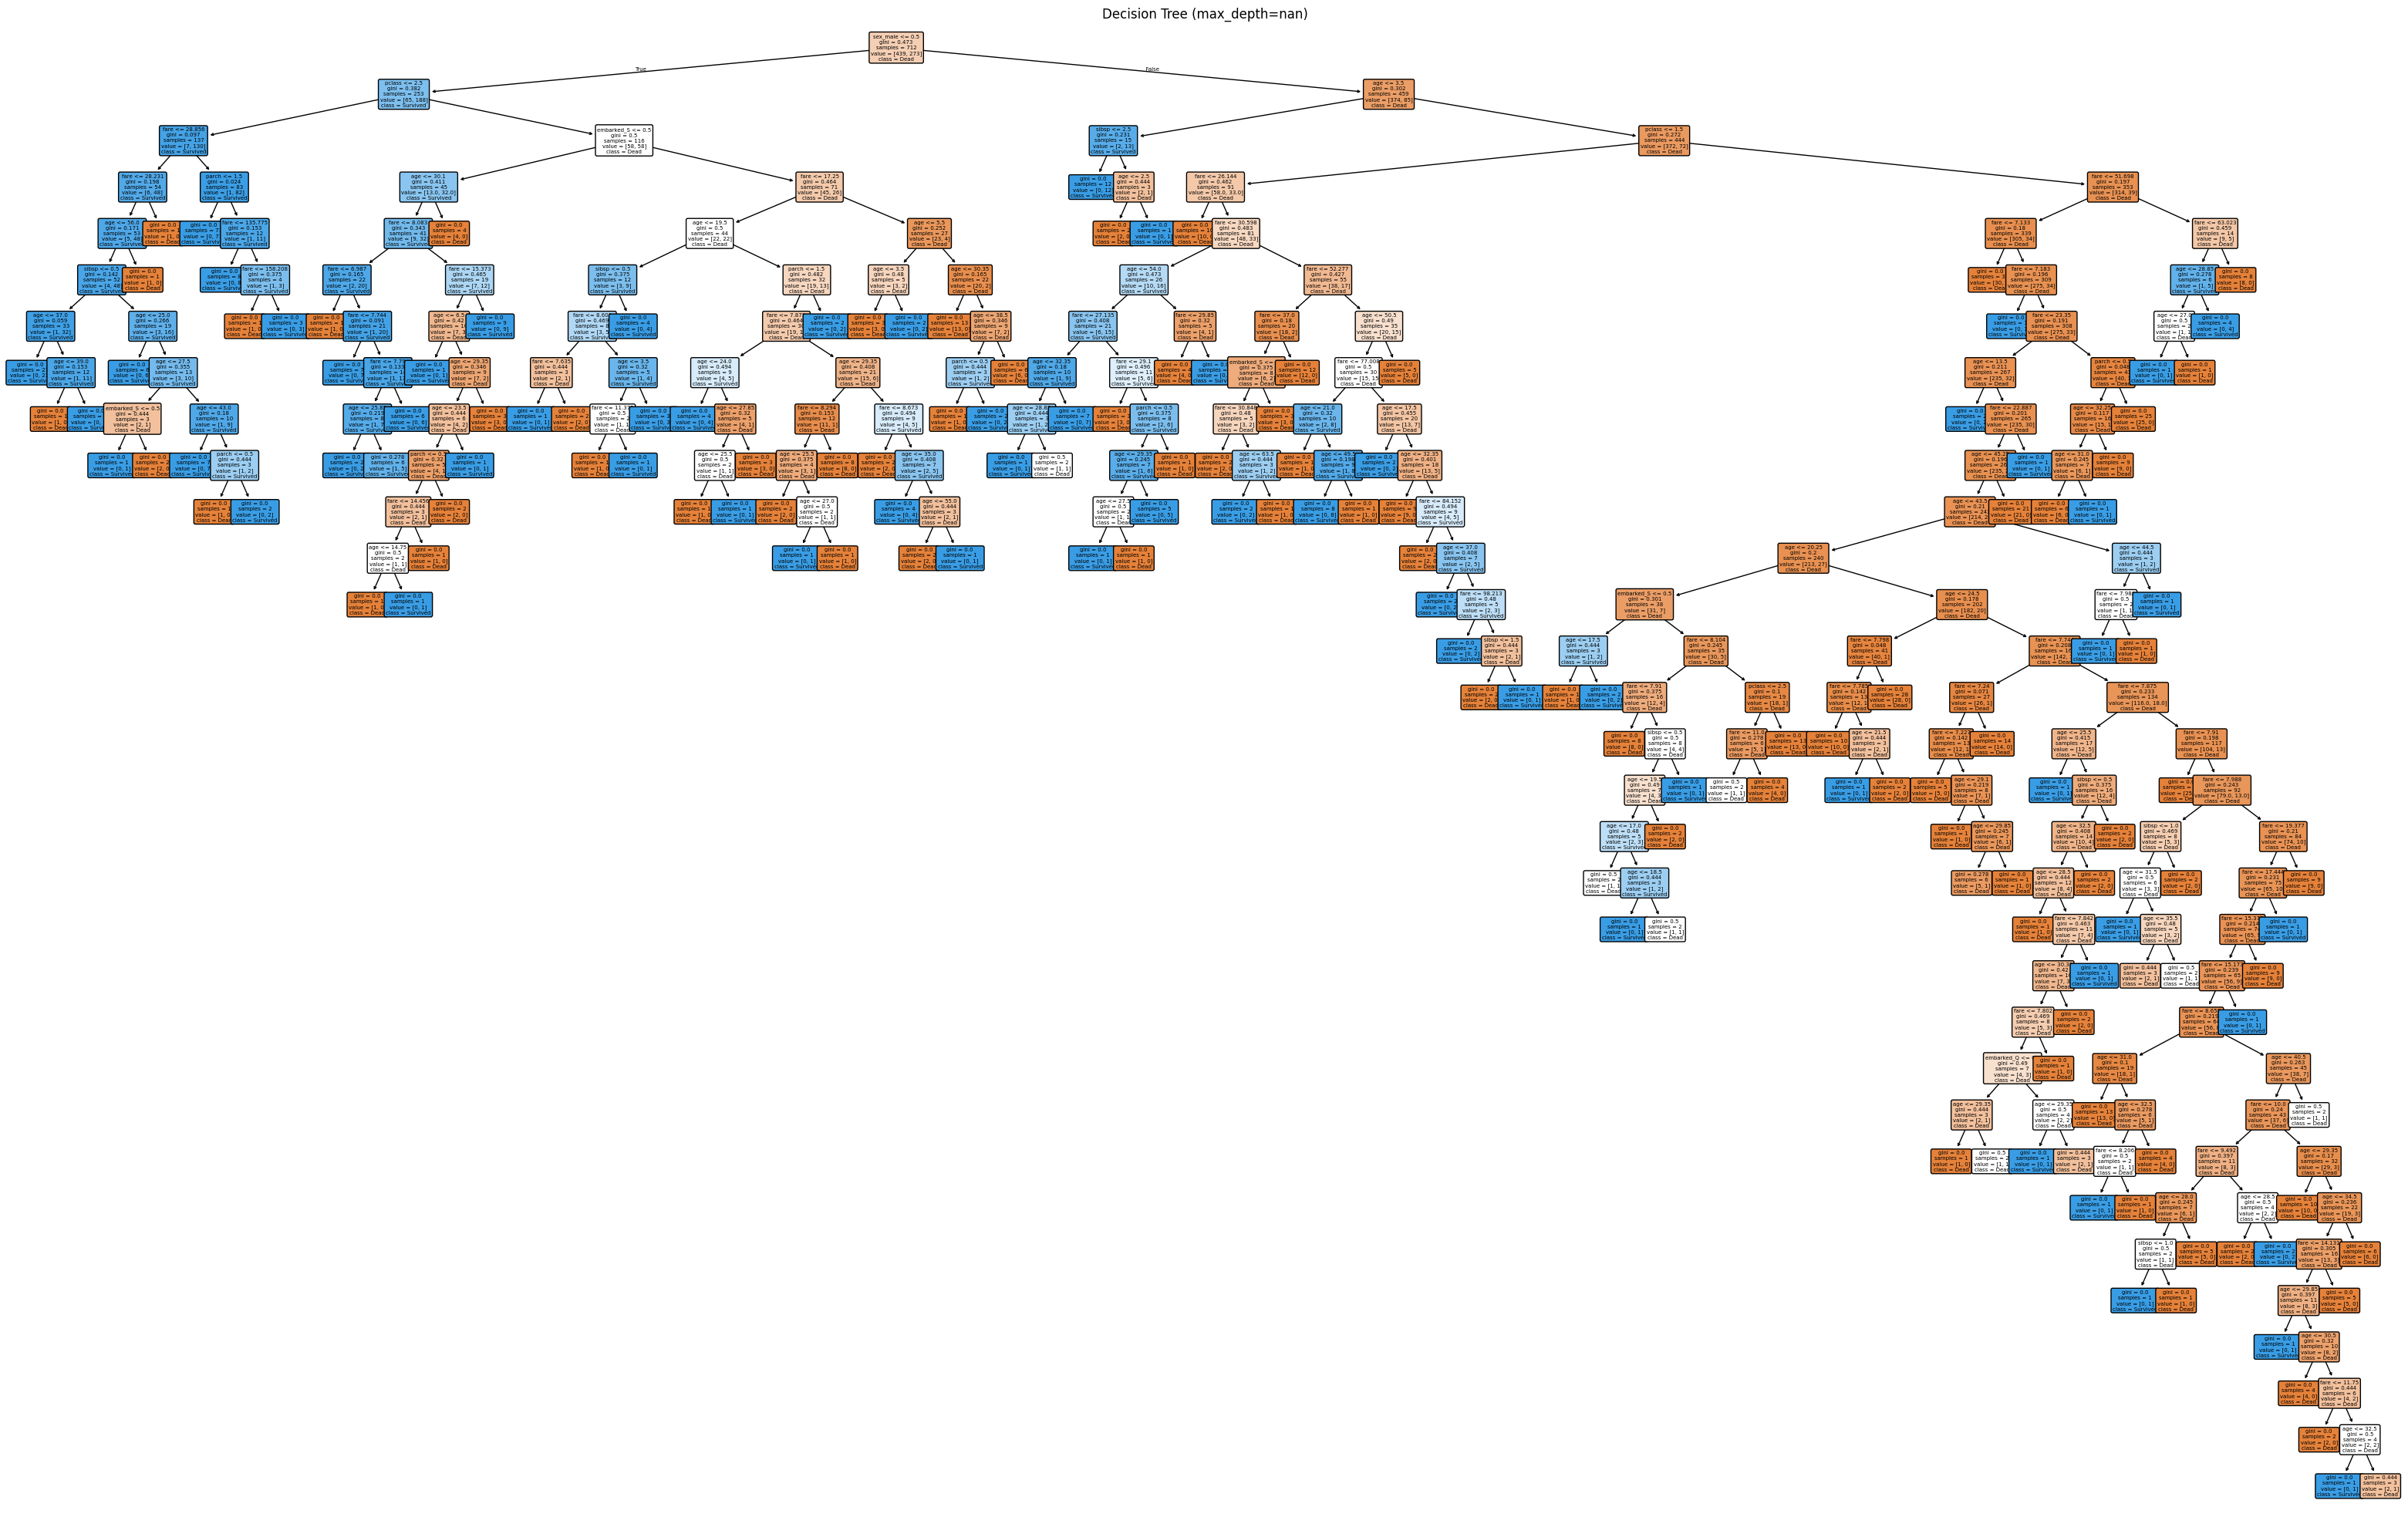

In [123]:
plt.figure(figsize=(40, 25))
plot_tree(best_score["model"],
          feature_names=X.columns,
          class_names=["Dead", "Survived"],
          filled=True,
          rounded=True,
          fontsize=5)
plt.title(f"Decision Tree (max_depth={best_score["depth"]})")
plt.show()

## Część 3: KNN - eksperyment z hiperparametrami

### 3.1 Znormalizuj cechy (StandardScaler)

In [124]:
numerical_columns = X_train.select_dtypes(include=["int64", "float64"]).columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()
scaler.fit(X_train[numerical_columns])
X_train_scaled[numerical_columns] = scaler.transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

print(f"\n---numerical_columns:\n{numerical_columns}")
print(f"\n---describe:\n{X_train_scaled.describe()}")
print(f"\n---head:\n{X_train_scaled.head()}")


---numerical_columns:
Index(['pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object')

---describe:
             pclass           age         sibsp         parch          fare
count  7.120000e+02  7.120000e+02  7.120000e+02  7.120000e+02  7.120000e+02
mean  -1.821265e-16  3.892018e-16 -5.613487e-18 -1.621674e-17 -1.746418e-17
std    1.000703e+00  1.000703e+00  1.000703e+00  1.000703e+00  1.000703e+00
min   -1.571457e+00 -2.257945e+00 -4.650843e-01 -4.661832e-01 -6.625632e-01
25%   -3.709448e-01 -5.987089e-01 -4.650843e-01 -4.661832e-01 -4.981542e-01
50%    8.295675e-01 -6.741426e-03 -4.650843e-01 -4.661832e-01 -3.615930e-01
75%    8.295675e-01  4.777189e-01  4.783345e-01 -4.661832e-01 -1.707070e-02
max    8.295675e-01  3.860778e+00  7.082266e+00  6.697610e+00  1.000533e+01

---head:
       pclass       age     sibsp     parch      fare  sex_male  embarked_Q  embarked_S
692  0.829568 -0.006741 -0.465084 -0.466183  0.513812      True       False        True
481 -0.370945 -0.006741 -0

### 3.2 Przetestuj *k* = 1, 3, 5, 7, 9, 11, 15

In [125]:
k_values = [1, 3, 5, 7, 9, 11, 15]
scores = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    scores.append({
        "model": model,
        "k": k,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })

scores_df = pd.DataFrame(scores)

print(scores_df)

                                  model   k  accuracy  precision    recall        f1
0   KNeighborsClassifier(n_neighbors=1)   1  0.743017   0.653333  0.710145  0.680556
1   KNeighborsClassifier(n_neighbors=3)   3  0.815642   0.781250  0.724638  0.751880
2                KNeighborsClassifier()   5  0.821229   0.813559  0.695652  0.750000
3   KNeighborsClassifier(n_neighbors=7)   7  0.787709   0.746032  0.681159  0.712121
4   KNeighborsClassifier(n_neighbors=9)   9  0.782123   0.741935  0.666667  0.702290
5  KNeighborsClassifier(n_neighbors=11)  11  0.787709   0.762712  0.652174  0.703125
6  KNeighborsClassifier(n_neighbors=15)  15  0.787709   0.781818  0.623188  0.693548


### 3.3 Narysuj wykres: accuracy w funkcji *k*

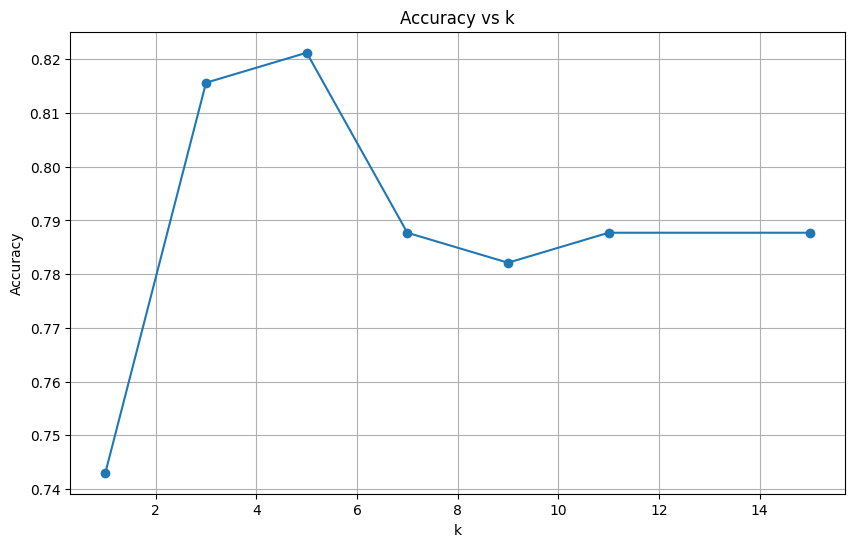

In [126]:
plt.figure(figsize=(10, 6))
plt.plot(scores_df["k"], scores_df["accuracy"], marker="o")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Accuracy vs k")
plt.grid(True)
plt.show()

### 3.4 Które *k* jest optymalne?

In [127]:
best_score = np.argmax(scores_df["accuracy"])
best_score = scores_df.iloc[best_score]

print(f"---Best accuracy: {best_score["accuracy"]}")
print(f"\n---Best score:\n{best_score}")

---Best accuracy: 0.8212290502793296

---Best score:
model        KNeighborsClassifier()
k                                 5
accuracy                   0.821229
precision                  0.813559
recall                     0.695652
f1                             0.75
Name: 2, dtype: object


Mimo że najlepszym pod względem **accuracy** jest model z k=5, to optymalnym może być model z k=7